columns of categorical data: Index(['date', 'home_club_manager_name', 'away_club_manager_name', 'stadium',
       'referee', 'home_club_name', 'away_club_name', 'competition_type'],
      dtype='object')
Number of rows before imputing missing values: 4078
Number of columns before imputing missing values: 228
[[129  40  68]
 [ 72  39  93]
 [ 55  42 278]]
              precision    recall  f1-score   support

          -1       0.50      0.54      0.52       237
           0       0.32      0.19      0.24       204
           1       0.63      0.74      0.68       375

    accuracy                           0.55       816
   macro avg       0.49      0.49      0.48       816
weighted avg       0.52      0.55      0.53       816

0.5465686274509803
R² score: -0.25538984236428597


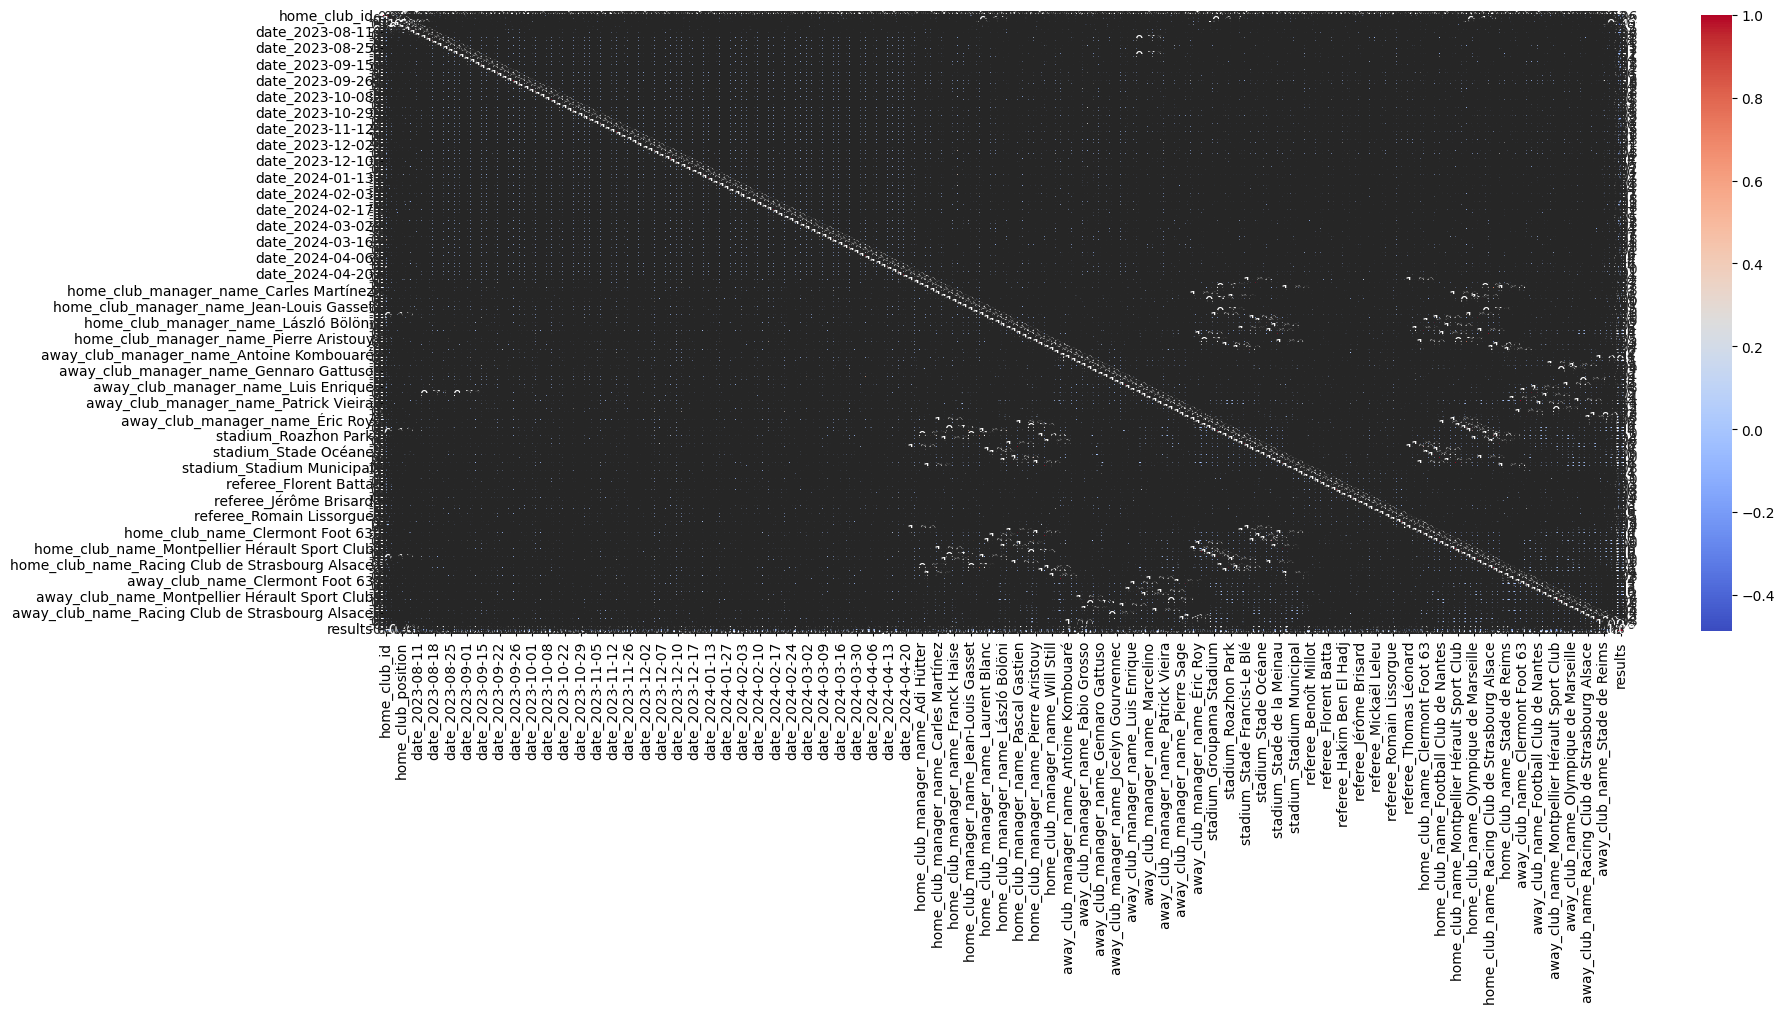

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

data = pd.read_csv("data\matchs_2013_2022.csv", sep=",")
dataAPredire = pd.read_csv("data\match_2023.csv", sep=",")
y = data["results"]
X = data[["home_club_id", "away_club_id","season","home_club_position","away_club_position","attendance"]]
# print(X.head(), y.head())

# categoricalData = data[["home_club_formation", "away_club_formation","competition_type"]]
categoricalData = dataAPredire.select_dtypes(include=['object'])
# categoricalData = categoricalData.drop(columns=["date","home_club_name","away_club_name","home_club_manager_name","away_club_manager_name","referee"])
print(f'columns of categorical data: {categoricalData.columns}'),
dataToOHE = categoricalData
ohe = OneHotEncoder()
dataToOHEEncoded = ohe.fit_transform(categoricalData).toarray()
categoricalDataFrame = pd.DataFrame(dataToOHEEncoded, columns=ohe.get_feature_names_out())

X = pd.concat([X, categoricalDataFrame], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data  
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model selection
model = RandomForestClassifier()

max_missing = 10
missing_values = X.isna().sum()

if all(missing_values < max_missing):
    imputer = SimpleImputer(strategy='mean')
else:
    imputer = SimpleImputer(strategy='most_frequent', fill_value=0)


pipeline = Pipeline([
    ('imputer', imputer),
    ('model', model)
])
print(f'Number of rows before imputing missing values: {len(X)}')
print(f'Number of columns before imputing missing values: {X.shape[1]}')


pipeline.fit(X_train, y_train)

# Model evaluation
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(pipeline.score(X_test, y_test))

r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

import matplotlib.pyplot as plt
import seaborn as sns

matCorr = pd.DataFrame(X)
matCorr['results'] = y

correlation_matrix = matCorr.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()